In [1]:
# 1. ─── Imports & Constants ──────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as kp_image

from sklearn.metrics import classification_report, confusion_matrix

# Adjust these if your data folder is named differently
DATA_DIR    = "data"  
CLASS_NAMES = ["plastic", "metal", "glass", "paper", "cardboard", "trash"]
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
EPOCHS      = 20


/Users/raman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# 2. ─── Cleanup: Remove any non‑image or corrupted files ────────────────────
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
bad_files = []

for root, _, files in os.walk(DATA_DIR):
    for fname in files:
        path = os.path.join(root, fname)
        ext = os.path.splitext(fname)[1].lower()
        # wrong extension?
        if ext not in valid_exts:
            bad_files.append(path)
            continue
        # corrupted image?
        try:
            img = Image.open(path)
            img.verify()
        except:
            bad_files.append(path)

for f in bad_files:
    os.remove(f)

print(f"Removed {len(bad_files)} invalid files.")


Removed 4 invalid files.


In [4]:
# 3. ─── Inspect Folder Counts ────────────────────────────────────────────────
for split in ["train", "val", "test"]:
    counts = {cls: len(os.listdir(os.path.join(DATA_DIR, split, cls)))
              if os.path.exists(os.path.join(DATA_DIR, split, cls)) else 0
              for cls in CLASS_NAMES}
    print(f"{split:>5}:", counts)


train: {'plastic': 482, 'metal': 820, 'glass': 1002, 'paper': 2237, 'cardboard': 463, 'trash': 1049}
  val: {'plastic': 482, 'metal': 820, 'glass': 1002, 'paper': 2237, 'cardboard': 463, 'trash': 1049}
 test: {'plastic': 482, 'metal': 820, 'glass': 1002, 'paper': 2237, 'cardboard': 463, 'trash': 1049}


In [5]:
# 4. ─── Load Datasets ────────────────────────────────────────────────────────
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)


Found 6053 files belonging to 6 classes.
Found 6053 files belonging to 6 classes.
Found 6053 files belonging to 6 classes.


2025-06-30 22:10:24.967439: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


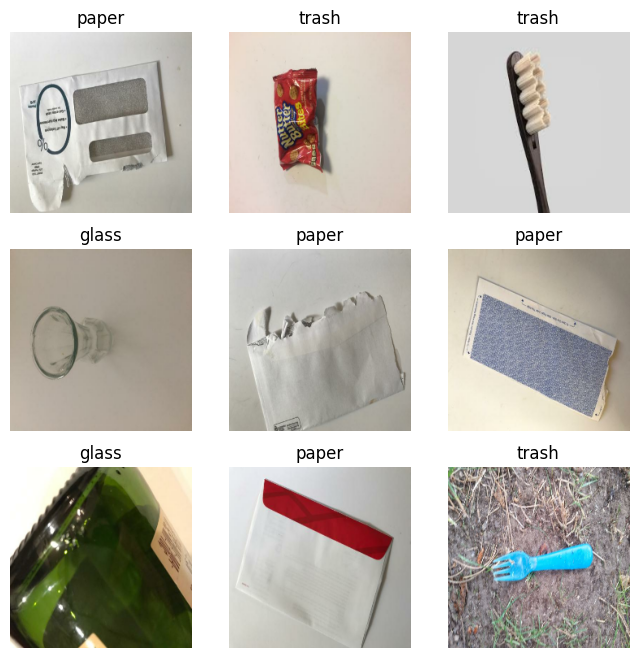

In [6]:
# 5. ─── (Optional) Visualize a Batch ────────────────────────────────────────
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(CLASS_NAMES[labels[i]])
        ax.axis("off")
plt.show()


In [10]:
# 6. ─── Data Augmentation Pipeline ──────────────────────────────────────────
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255)
])


In [11]:
# 7. ─── Build & Compile the Model ───────────────────────────────────────────
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
import tensorflow as tf
import os

bad = []
for split in ["train","val","test"]:
    folder = os.path.join(DATA_DIR, split)
    for root, _, files in os.walk(folder):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                # Try reading & decoding the file
                raw = tf.io.read_file(path)
                _   = tf.io.decode_image(raw)
            except Exception as e:
                bad.append(path)

print("Bad files found:", len(bad))
for p in bad:
    print(" ", p)


Bad files found: 0


In [15]:
import tensorflow as tf

still_bad = []
for split in ["train","val","test"]:
    for root, _, files in os.walk(os.path.join(DATA_DIR, split)):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                raw = tf.io.read_file(path)
                _   = tf.io.decode_image(raw)
            except:
                still_bad.append(path)

print("Still failing to decode:", still_bad)


Still failing to decode: []


In [16]:
import tensorflow as tf
from tensorflow.keras import layers

# 1) Reload datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

# 2) (Re)build model components if needed
#    (Assuming data_augmentation, base_model, and model are already defined;
#     otherwise re-run their definition cells.)

# 3) Train
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Found 6053 files belonging to 6 classes.
Found 6053 files belonging to 6 classes.
Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2837 - loss: 1.7231

190/190 ━━━━━━━━━━━━━━━━━━━━ 108s 555ms/step - accuracy: 0.2840 - loss: 1.7228 - val_accuracy: 0.3696 - val_loss: 1.6404
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 108s 570ms/step - accuracy: 0.3678 - loss: 1.6456 - val_accuracy: 0.3696 - val_loss: 1.6408
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 114s 601ms/step - accuracy: 0.3716 - loss: 1.6444 - val_accuracy: 0.3696 - val_loss: 1.6413
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3706 - loss: 1.6437

190/190 ━━━━━━━━━━━━━━━━━━━━ 111s 586ms/step - accuracy: 0.3706 - loss: 1.6437 - val_accuracy: 0.3696 - val_loss: 1.6404
Epoch 5/20
 56/190 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - accuracy: 0.3759 - loss: 1.6306

KeyboardInterrupt: 

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 3613 files belonging to 6 classes.


In [16]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2%}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - accuracy: 0.4643 - loss: 1.3103
Test accuracy: 46.42%


In [17]:
# 9. ─── Evaluate on Test Set ─────────────────────────────────────────────────
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2%}")

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(
    y_true, y_pred,
    labels=list(range(len(CLASS_NAMES))),
    target_names=CLASS_NAMES,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
print("Confusion Matrix:\n", cm)


113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - accuracy: 0.4679 - loss: 1.3018
Test accuracy: 46.42%
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step
              precision    recall  f1-score   support

     plastic       0.00      0.00      0.00        18
       metal       0.00      0.00      0.00       410
       glass       0.00      0.00      0.00       501
       paper       0.46      1.00      0.63      1677
   cardboard       0.00      0.00      0.00        60
       trash       0.00      0.00      0.00       947

    accuracy                           0.46      3613
   macro avg       0.08      0.17      0.11      3613
weighted avg       0.22      0.46      0.29      3613

Confusion Matrix:
 [[   0    0    0   18    0    0]
 [   0    0    0  410    0    0]
 [   0    0    0  501    0    0]
 [   0    0    0 1677    0    0]
 [   0    0    0   60    0    0]
 [   0    0    0  947    0    0]]


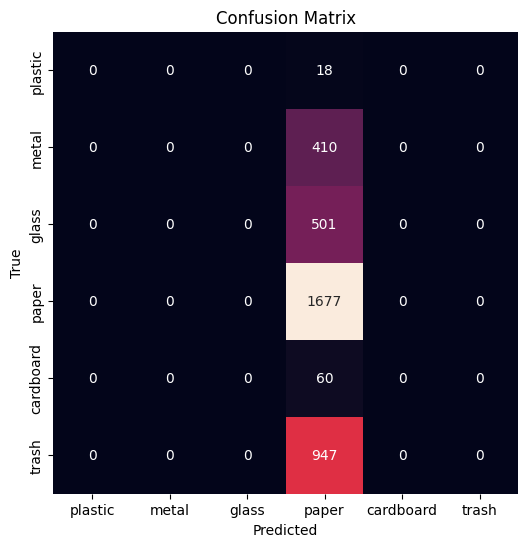

In [18]:
# 10. ─── Plot Confusion Matrix ───────────────────────────────────────────────
import seaborn as sns

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# 11. ─── Single‑Image Inference & Save Model ─────────────────────────────────
def predict_image(path):
    img = kp_image.load_img(path, target_size=IMG_SIZE)
    x   = kp_image.img_to_array(img) / 255.0
    x   = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]
    idx   = np.argmax(preds)
    return CLASS_NAMES[idx], preds[idx]

# Example:
label, conf = predict_image("data/test/glass/glass20.jpg")
print(f"Prediction: {label} ({conf:.2%})")

model.save("waste_classifier_final.h5")
print("Saved model to waste_classifier_final.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


Prediction: paper (47.38%)
Saved model to waste_classifier_final.h5


In [26]:
# 1. ─── Imports & Constants ───────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models
from tensorflow.keras.preprocessing import image as kp_image

from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix

# Paths & parameters
DATA_DIR    = "data"   # root folder with train/val/test subfolders
CLASS_NAMES = ["plastic", "metal", "glass", "paper", "cardboard", "trash"]
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
EPOCHS_HEAD = 5        # train only classification head
EPOCHS_FINE = 10       # fine‑tune top layers


In [27]:
# 2. ─── (Optional) Cleanup any bad files ─────────────────────────────────
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
bad_files = []

for root, _, files in os.walk(DATA_DIR):
    for fname in files:
        path = os.path.join(root, fname)
        ext  = os.path.splitext(fname)[1].lower()
        if ext not in valid_exts:
            bad_files.append(path)
            continue
        try:
            img = Image.open(path); img.verify()
        except:
            bad_files.append(path)

for f in bad_files:
    os.remove(f)
print(f"Removed {len(bad_files)} invalid files.")


Removed 0 invalid files.


In [28]:
# 3. ─── Inspect folder counts ──────────────────────────────────────────────
for split in ["train", "val", "test"]:
    counts = {
        cls: len(os.listdir(os.path.join(DATA_DIR, split, cls)))
        if os.path.exists(os.path.join(DATA_DIR, split, cls)) else 0
        for cls in CLASS_NAMES
    }
    print(f"{split:>5}:", counts)


train: {'plastic': 482, 'metal': 820, 'glass': 1002, 'paper': 2237, 'cardboard': 463, 'trash': 1049}
  val: {'plastic': 482, 'metal': 820, 'glass': 1002, 'paper': 2237, 'cardboard': 463, 'trash': 1049}
 test: {'plastic': 482, 'metal': 820, 'glass': 1002, 'paper': 2237, 'cardboard': 463, 'trash': 1049}


In [29]:
# 4. ─── Load datasets ───────────────────────────────────────────────────────
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)


Found 6053 files belonging to 6 classes.
Found 6053 files belonging to 6 classes.
Found 6053 files belonging to 6 classes.


In [32]:
# 5. ─── Data augmentation + EfficientNetV2 preprocessing ──────────────────
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Lambda(preprocess_input),  # use EfficientNetV2 preprocessor
])


In [34]:
# 6. ─── Build & compile model (head only) ──────────────────────────────────
base_model = EfficientNetV2B0(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)
base_model.trainable = False  # freeze backbone

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [36]:
# 7. ─── Phase 1: Train only the new head ───────────────────────────────────
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=[
        callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    ]
)


Epoch 1/5
 26/190 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - accuracy: 0.8874 - loss: 0.3765

KeyboardInterrupt: 

In [38]:
# 8. ─── Phase 2: Unfreeze top layers & fine‑tune ─────────────────────────────
base_model.trainable = True
# freeze all but last 20 layers of the backbone
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lr_reducer = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE,
    callbacks=[lr_reducer]
)


Epoch 1/10


Exception ignored in: <function AtomicFunction.__del__ at 0x1212323a0>
Traceback (most recent call last):
  File "/Users/raman/Library/Python/3.9/lib/python/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


 13/190 ━━━━━━━━━━━━━━━━━━━━ 48s 272ms/step - accuracy: 0.8608 - loss: 0.3902

KeyboardInterrupt: 

In [39]:
# 9. ─── Evaluate on test set ───────────────────────────────────────────────
loss, acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {acc:.2%}\n")

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(
    y_true, y_pred,
    labels=list(range(len(CLASS_NAMES))),
    target_names=CLASS_NAMES,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
print("Confusion Matrix:\n", cm)


190/190 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.9388 - loss: 0.1750

Test accuracy: 93.82%



2025-06-30 22:52:53.402463: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


190/190 ━━━━━━━━━━━━━━━━━━━━ 42s 216ms/step
              precision    recall  f1-score   support

     plastic       0.09      0.09      0.09       482
       metal       0.16      0.18      0.17       820
       glass       0.18      0.18      0.18      1002
       paper       0.36      0.37      0.36      2237
   cardboard       0.08      0.08      0.08       463
       trash       0.18      0.16      0.17      1049

    accuracy                           0.23      6053
   macro avg       0.17      0.18      0.17      6053
weighted avg       0.23      0.23      0.23      6053

Confusion Matrix:
 [[ 41  68  61 188  39  85]
 [ 59 144 126 306  66 119]
 [ 69 147 180 374  66 166]
 [178 331 377 818 172 361]
 [ 34  66  81 165  37  80]
 [ 84 153 169 396  74 173]]


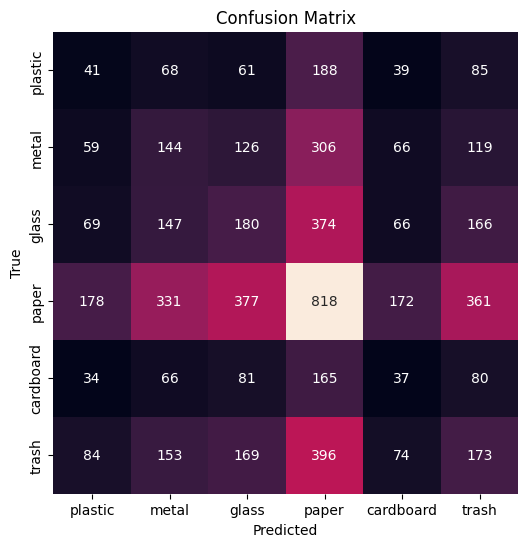

In [40]:
# 10. ─── Plot confusion matrix ──────────────────────────────────────────────
import seaborn as sns

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 11. ─── Single‑image inference & save final model ─────────────────────────
def predict_image(path):
    img = kp_image.load_img(path, target_size=IMG_SIZE)
    x = kp_image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, 0)
    preds = model.predict(x)[0]
    idx = np.argmax(preds)
    return CLASS_NAMES[idx], preds[idx]

# Example:
label, conf = predict_image("data/test/glass/glass20.jpg")
print(f"Prediction: {label} ({conf:.2%})")

model.save("waste_classifier_v2b0.keras")
print("Saved model as waste_classifier_v2b0.keras")
